<a href="https://colab.research.google.com/github/romenmeitei/Dengue-cases-in-Manipur/blob/main/Correlation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing Values:
 Time                         0
Total Cases                  0
IgM Mac ELISA Postive        0
NS1 Antigen ELISA Postive    0
Temperature (°C)             0
Precipitation (mm)           0
NDVI                         0
dtype: int64
                      Time  Total Cases  IgM Mac ELISA Postive  \
count                   72    72.000000              72.000000   
mean   2021-12-15 22:40:00    23.204861              13.138889   
min    2019-01-01 00:00:00     0.000000               0.000000   
25%    2020-06-23 12:00:00     1.000000               0.000000   
50%    2021-12-16 12:00:00     8.000000               7.000000   
75%    2023-06-08 12:00:00    32.250000              22.000000   
max    2024-12-01 00:00:00    79.125000              55.000000   
std                    NaN    29.960584              16.110801   

       NS1 Antigen ELISA Postive  Temperature (°C)  Precipitation (mm)  \
count                  72.000000      7.200000e+01        7.200000e+01   
mean      

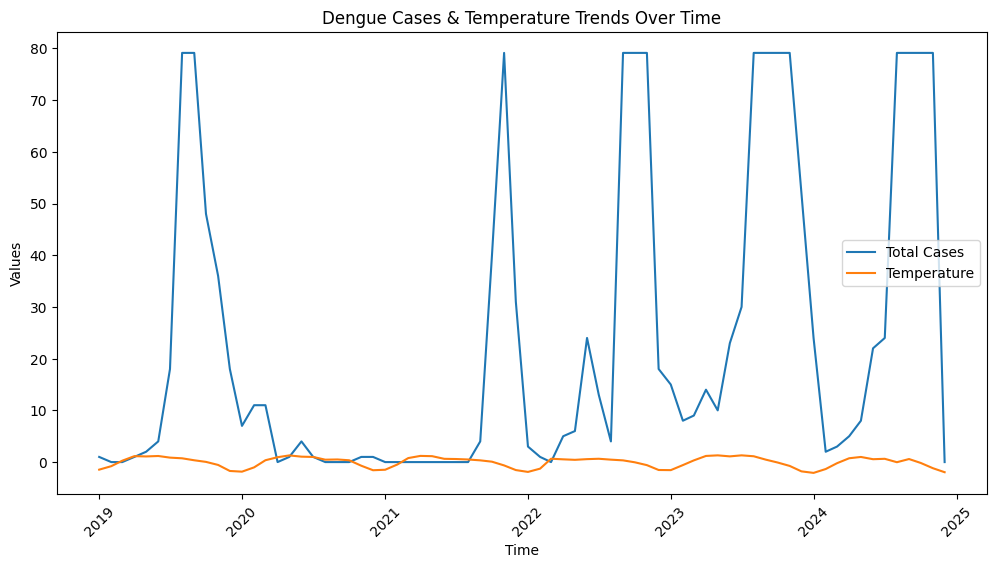

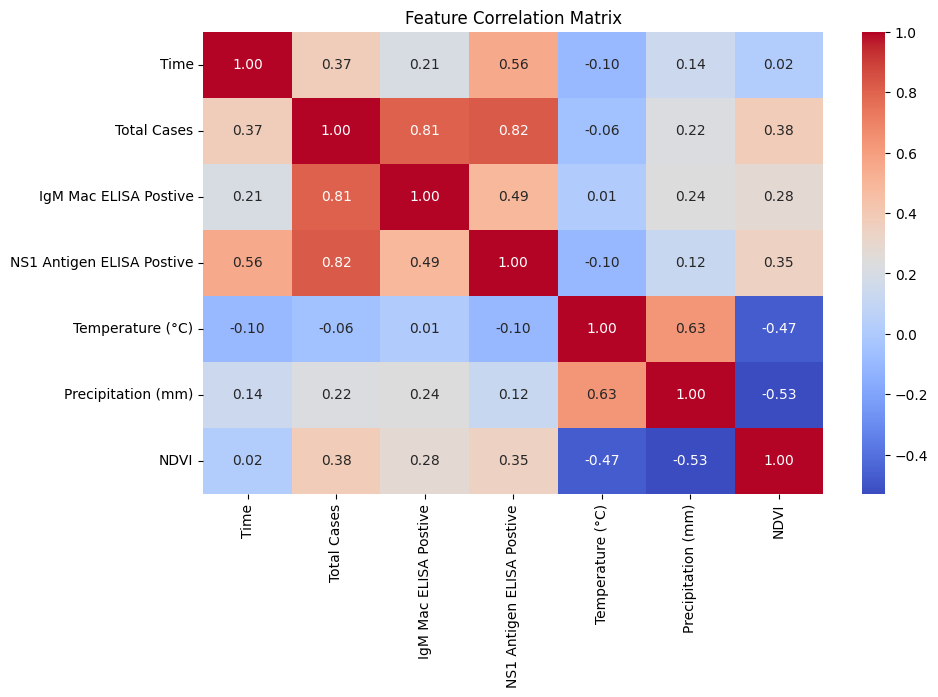

ANCOVA Results:
                            df        sum_sq       mean_sq          F  \
Q('Temperature (°C)')     1.0    198.067524    198.067524   0.360480   
Q('Precipitation (mm)')   1.0   7008.547678   7008.547678  12.755443   
Q('NDVI')                 1.0  19162.610974  19162.610974  34.875641   
Residual                 68.0  37362.970872    549.455454        NaN   

                               PR(>F)  
Q('Temperature (°C)')    5.502358e-01  
Q('Precipitation (mm)')  6.573970e-04  
Q('NDVI')                1.242477e-07  
Residual                          NaN  
MSE: 396.49259333701644
R2 Score: 0.4491472076759382


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

# Load datasets
df_climate = pd.read_csv("/content/generated_climate_data.csv")
df_cases = pd.read_excel("Final Dataset.xlsx", sheet_name="Sheet")

# Convert "Months" to numerical format
month_mapping = {
    'Jan': '01', 'Feb': '02', 'March': '03', 'April': '04', 'May': '05', 'June': '06',
    'July': '07', 'Aug': '08', 'Sept': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}

df_cases['Months'] = df_cases['Months'].map(month_mapping)

# Create "Time" column in "YYYY-MM" format
df_cases['Time'] = df_cases['Year'].astype(str) + '-' + df_cases['Months']

# Drop original Year and Months columns
df_cases.drop(columns=['Year', 'Months'], inplace=True)

# Aggregate dengue cases across districts per month
df_cases_agg = df_cases.groupby("Time")[["Total Cases", "IgM Mac ELISA Postive", "NS1 Antigen ELISA Postive"]].sum().reset_index()

# Merge datasets on "Time"
final_df = pd.merge(df_cases_agg, df_climate, on="Time", how="left")

# Convert "Time" column to datetime format
final_df['Time'] = pd.to_datetime(final_df['Time'])

# Check for missing values
print("Missing Values:\n", final_df.isnull().sum())

# Convert to appropriate data types
final_df["Total Cases"] = final_df["Total Cases"].astype(float)

# Identify numerical columns for outlier handling
numeric_cols = final_df.select_dtypes(include=["float64", "int64"]).columns

# Handle outliers using IQR (Winsorization)
Q1 = final_df[numeric_cols].quantile(0.25)
Q3 = final_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
final_df[numeric_cols] = final_df[numeric_cols].clip(lower=lower_bound, upper=upper_bound, axis=1)

# Standardize numerical features
scaler = StandardScaler()
features = ["Temperature (°C)", "Precipitation (mm)", "NDVI"]
final_df[features] = scaler.fit_transform(final_df[features])

# Display summary statistics
print(final_df.describe())

# ----- Exploratory Data Analysis (EDA) -----
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x="Time", y="Total Cases", label="Total Cases")
sns.lineplot(data=final_df, x="Time", y="Temperature (°C)", label="Temperature")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.title("Dengue Cases & Temperature Trends Over Time")
plt.xticks(rotation=45)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(final_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# ----- Statistical Analysis (ANCOVA) -----
model = ols("Q('Total Cases') ~ Q('Temperature (°C)') + Q('Precipitation (mm)') + Q('NDVI')", data=final_df).fit()
ancova_table = anova_lm(model)
print("ANCOVA Results:\n", ancova_table)

# ----- Machine Learning (Linear Regression) -----
X = final_df[["Temperature (°C)", "Precipitation (mm)", "NDVI"]]
y = final_df["Total Cases"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Performance
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

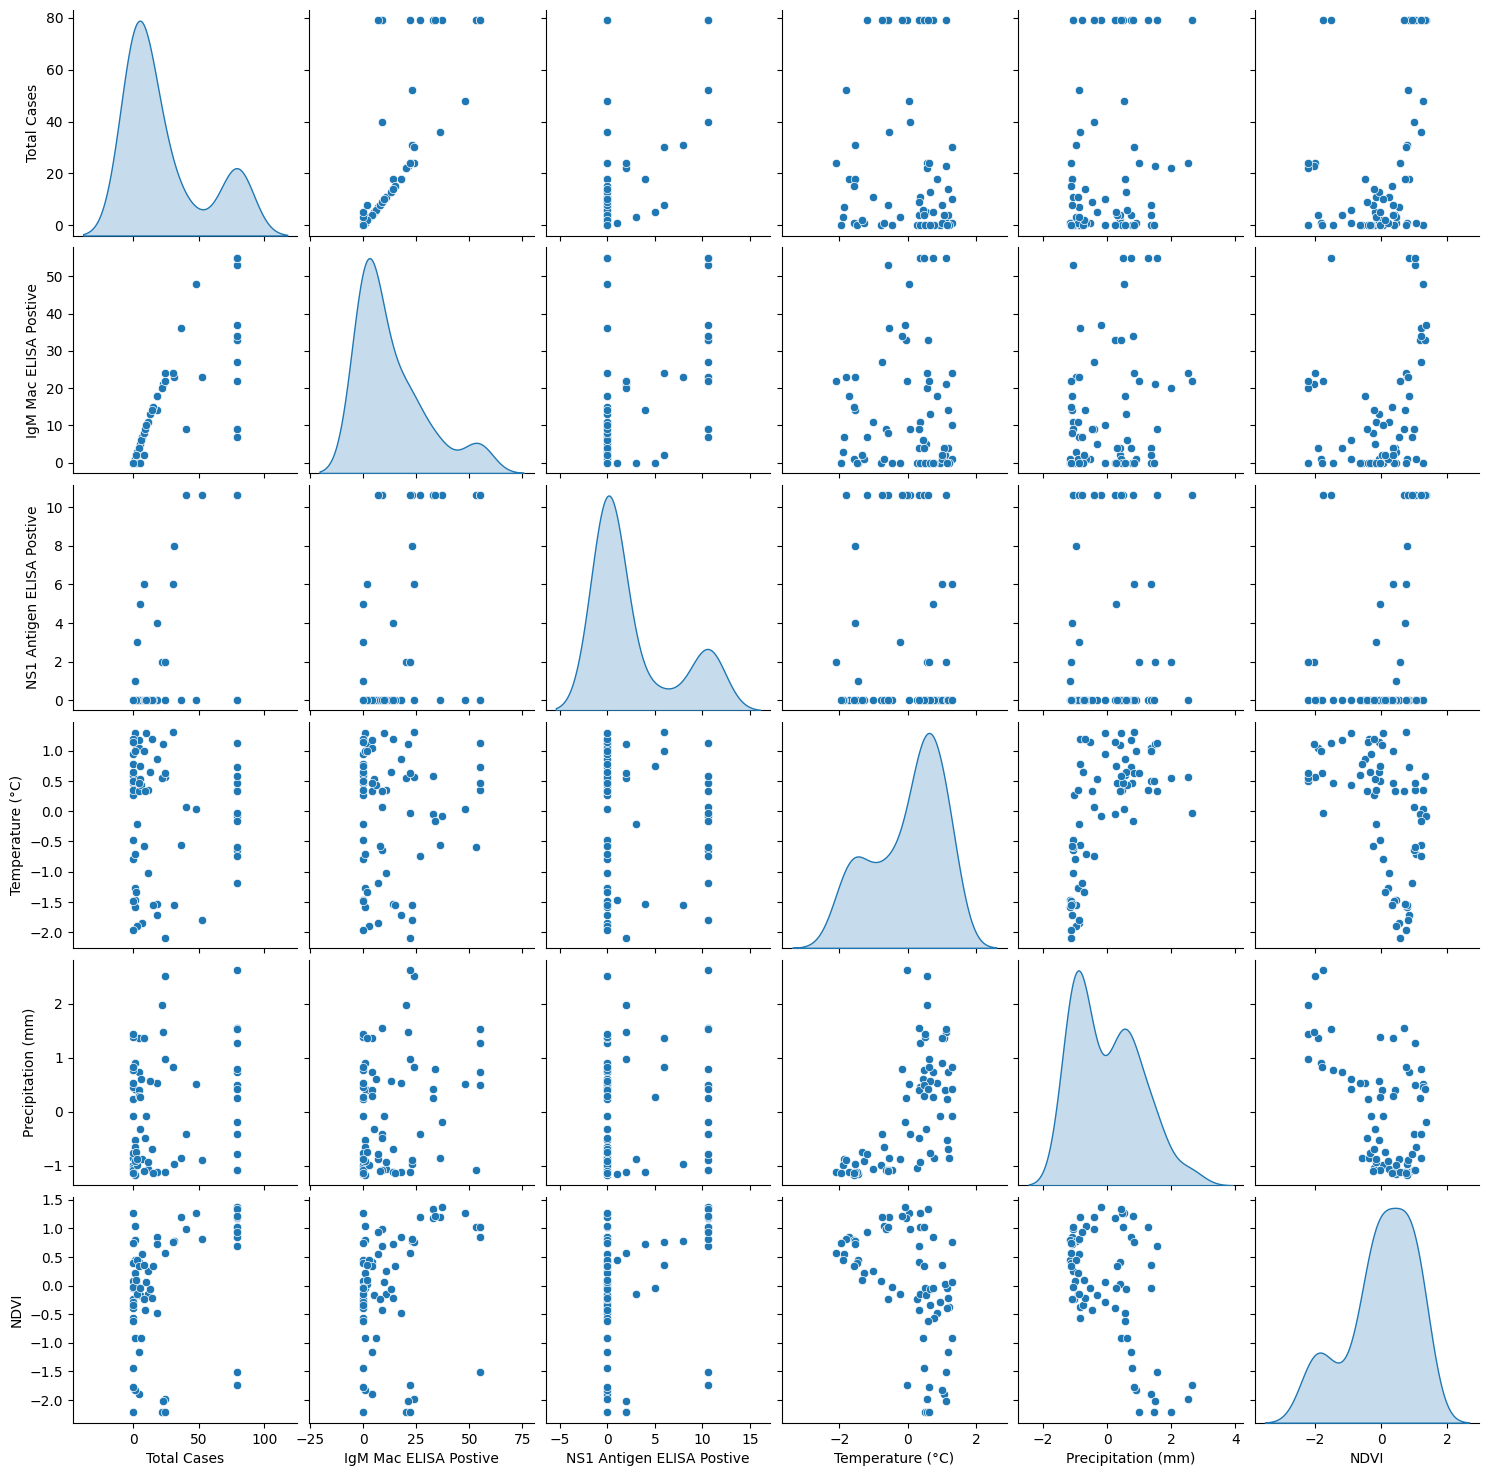

In [ ]:
sns.pairplot(final_df, diag_kind='kde')
plt.show()


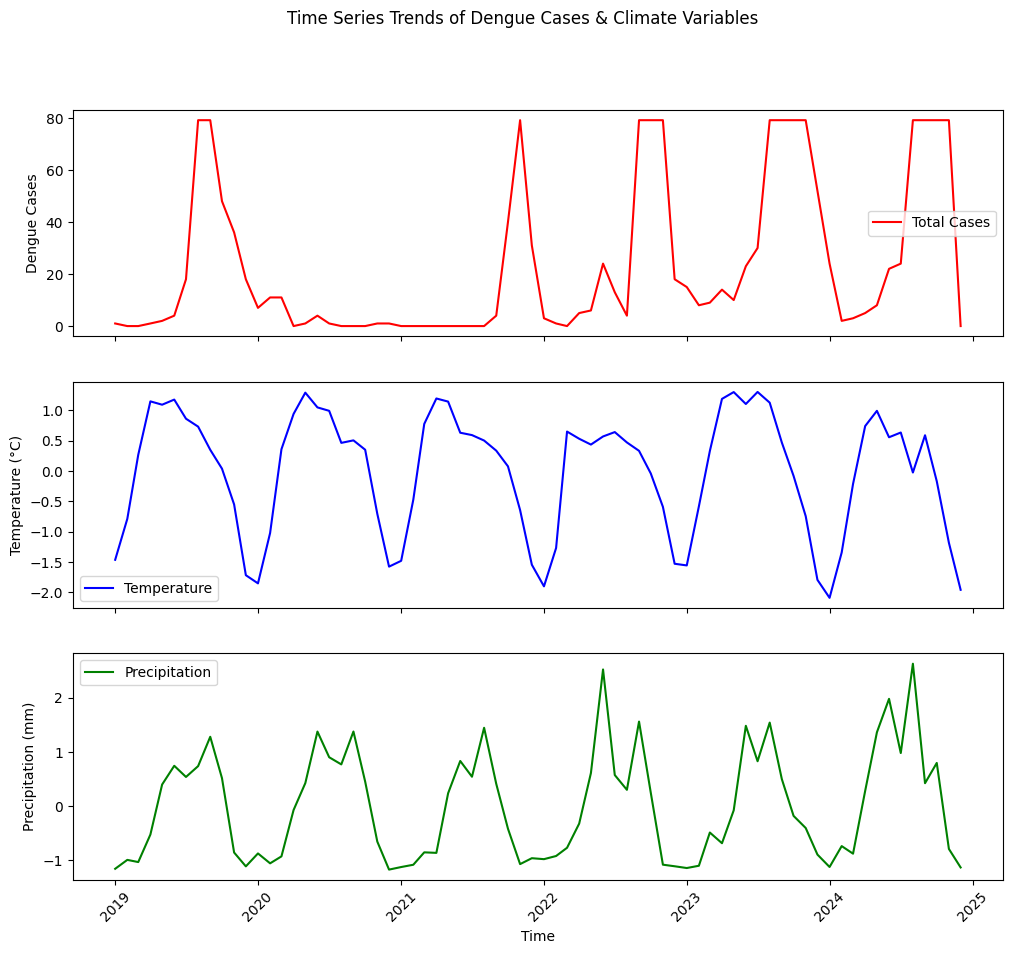

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
sns.lineplot(ax=ax[0], data=final_df, x="Time", y="Total Cases", label="Total Cases", color="red")
sns.lineplot(ax=ax[1], data=final_df, x="Time", y="Temperature (°C)", label="Temperature", color="blue")
sns.lineplot(ax=ax[2], data=final_df, x="Time", y="Precipitation (mm)", label="Precipitation", color="green")

ax[0].set_ylabel("Dengue Cases")
ax[1].set_ylabel("Temperature (°C)")
ax[2].set_ylabel("Precipitation (mm)")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.suptitle("Time Series Trends of Dengue Cases & Climate Variables")
plt.show()


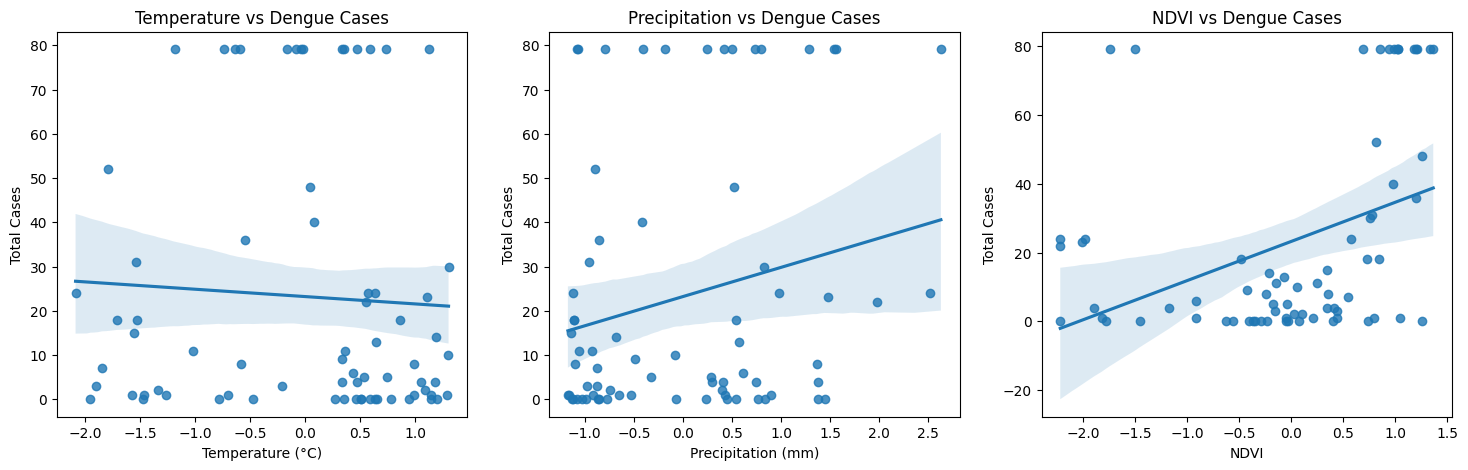

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.regplot(ax=axes[0], x=final_df["Temperature (°C)"], y=final_df["Total Cases"])
sns.regplot(ax=axes[1], x=final_df["Precipitation (mm)"], y=final_df["Total Cases"])
sns.regplot(ax=axes[2], x=final_df["NDVI"], y=final_df["Total Cases"])

axes[0].set_title("Temperature vs Dengue Cases")
axes[1].set_title("Precipitation vs Dengue Cases")
axes[2].set_title("NDVI vs Dengue Cases")
plt.show()
